# Text generation with LSTM and Transformer networks



## Installs the unidecode library and downloads the Shakespeare dataset.

In [2]:
!pip install unidecode
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

Defaulting to user installation because normal site-packages is not writeable


'wget' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
import math
import unidecode
import string
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.autograd import Variable
from torch.utils.data import Dataset

## LSTM implementation

For this task you will implement the LSTM neural network architecture and train it on the task of character-level text generation. Implement a single layer LSTM and optionally extend your implementation to multiple layers to generate better results.

Links:

- https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html -- Lists the equations for each component of the LSTM cell.
- http://colah.github.io/posts/2015-08-Understanding-LSTMs/ -- Intuitive explanation of LSTM
- http://karpathy.github.io/2015/05/21/rnn-effectiveness/ -- Explanation and uses of RNNs.


Implement the initialization and the forward pass of a LSTMCell and use it as part of the LSTMSimple network class.

The input of the LSTM network will be a sequence of characters, whereas the input of the LSTMCell will be a single input character (x), the output of the previous iteration (C) and the hidden state of the previous iteration (h). Iteratively process the entire input character sequence and calculate the loss based on the prediction at each time step.

### Do NOT use the torch.nn.LSTM class.


In [3]:
class LSTMCell(nn.Module):
  def __init__(self, input_dim, hidden_dim):
    super(LSTMCell, self).__init__()

    self.forget_gate = nn.Linear(input_dim + hidden_dim, hidden_dim)
    self.input_gate = nn.Linear(input_dim + hidden_dim, hidden_dim)
    self.output_gate = nn.Linear(input_dim + hidden_dim, hidden_dim)
    self.cell_gate = nn.Linear(input_dim + hidden_dim, hidden_dim)


  def forward(self, x, C, h):
    # x - batch of encoded characters
    # C - Cell state of the previous iteration
    # h - Hidden state of the previous iteration
    # Returns: cell state C_out and the hidden state h_out
    batch_size = x.size(0)
    concatination = torch.cat((x, h[:batch_size, :]), dim=1)

    # Thrown away info
    f = F.sigmoid(self.forget_gate(concatination))

    # New info and new candidate values
    i = F.sigmoid(self.input_gate(concatination))
    C_t = F.tanh(self.cell_gate(concatination))

    # Update cell state
    C_out = (f * C[:batch_size, :]) + (i * C_t)

    # Decide what to output and generate new hidden state
    o = F.sigmoid(self.output_gate(concatination))
    h_out = o * F.tanh(C_out)

    return C_out, h_out

In [10]:
class LSTMSimple(nn.Module):
  def __init__(self, seq_length, input_dim, hidden_dim, output_dim, batch_size):
    super(LSTMSimple, self).__init__()

    self.seq_length = seq_length
    self.hidden_dim = hidden_dim
    self.batch_size = batch_size

    self.lstm_cell = LSTMCell(input_dim, hidden_dim)
    self.proj = nn.Linear(hidden_dim, output_dim)


  def forward(self, x):
    # x - One hot encoded batch - Shape: (batch, seq_len, onehot_char)
    # Returns the predicted next character for each character in the
    # sequence (outputs), also returns the cell state and hidden state of the
    # LSTMCell call on the last character. -- outputs, (c,t)

    h = torch.zeros(self.batch_size, self.hidden_dim).to(x.device)
    C = torch.zeros(self.batch_size, self.hidden_dim).to(x.device)
    outputs = []

    if (x.shape[1] < self.seq_length):
      seq_len = x.shape[1]
    else:
      seq_len = self.seq_length

    for i in range(seq_len):
      x_t = x[:, i, :]

      C, h = self.lstm_cell(x_t, C, h)

      outputs.append(self.proj(h).unsqueeze(1))

    return torch.cat(outputs, dim=1), (C, h)

### LSTM Sampling Code

To generate text the network must predict the next character in a sequence, however networks do not produce a single character but rather estimate the likelihood for each possible character. Sampling characters from the network output can be done in different ways with common ones being the Greedy sampling process and Top-K sampling.

In the simple greedy sampling method the network takes a text prompt as input and generates an additional N tokens by always taking the token with the highest prediction score as the next token.

In the Top-K sampling, randomness is added to the sampling process as the network samples from K most likely predicitons at each step. This alleviates the problem of generative models repeating text but may generate incorrect text by sampling inappropriate tokens.


In [5]:
def greedy_sampling_lstm(lstm, x, num_chars):
  # x -- b x onehot_char
  outputs = torch.zeros((1, num_chars, x.shape[2]))
  t_outputs, (cell_state, hidden) = lstm(x.float())
  for c in range(num_chars):
    output_tmp = torch.softmax(lstm.proj(hidden), dim=1)
    top_ind = torch.argmax(output_tmp, dim=1)[0]
    tmp = torch.zeros_like(x[:, 0, :]).cuda()
    tmp[:, top_ind] = 1
    outputs[:, c] = tmp

    cell_state, hidden = lstm.lstm_cell(tmp, cell_state, hidden)
  return outputs

def topk_sampling_lstm(lstm, x, num_chars):
  # x -- b x onehot_char
  outputs = torch.zeros((1, num_chars, x.shape[2]))
  t_outputs, (cell_state, hidden) = lstm(x.float())
  for c in range(num_chars):
    output_vals, output_ind = torch.topk(lstm.proj(hidden), 5, dim=1)
    output_tmp = torch.softmax(output_vals, dim=1)
    top_ind = torch.multinomial(output_tmp[0], 1)[0]
    tmp = torch.zeros_like(x[:, 0, :]).cuda()
    tmp[:, output_ind[0, top_ind]] = 1
    outputs[:, c] = tmp

    cell_state, hidden = lstm.lstm_cell(tmp, cell_state, hidden)

  return outputs

### LSTM Dataset Code

In [6]:
class LSTMDataset(Dataset):
  def __init__(self, chunk_len=200, padded_chunks=False):
    # Character based dataset
    dataset_path = "./input.txt"
    # The tokens in the vocabulary (all_characters)
    # are just the printable characters of the string class
    self.all_characters = string.printable
    self.n_characters = len(self.all_characters)
    # Maps characters to indices
    self.char_dict = { x:i for i, x in enumerate(self.all_characters) }
    self.file, self.file_len = self.read_file(dataset_path)
    # Sequence length of the input
    self.chunk_len = chunk_len

  def read_file(self,filename):
    file = unidecode.unidecode(open(filename).read())
    return file, len(file)

  def char_tensor(self,in_str):
    # in_str - input sequence - String
    # Return one-hot encoded characters of in_str
    tensor = torch.zeros(len(in_str), self.n_characters).long()
    char_ind = [self.char_dict[c] for c in in_str]
    tensor[torch.arange(tensor.shape[0]),char_ind] = 1
    return tensor

  def __getitem__(self, idx):
    inp, target = self.get_random_text()
    return {"input":inp, "target":target}

  def __len__(self):
    return 10000

  def get_random_text(self):
    # Pick a random string of length self.chunk_len from the dataset
    start_index = np.random.randint(0, self.file_len - self.chunk_len)
    end_index = start_index + self.chunk_len + 1
    chunk = self.file[start_index:end_index]
    # One-hot encode the chosen string
    inp = self.char_tensor(chunk[:-1])
    # The target string is the same as the
    # input string but shifted by 1 character
    target = self.char_tensor(chunk[1:])
    inp = Variable(inp).cuda()
    target = Variable(target).cuda()
    return inp, target


In [75]:
def visualize_character_distribution(greedy_indices, topk_indices, all_characters, seq_len):
    epochs = len(greedy_indices)
    num_characters = len(all_characters)

    last_epoch_index = len(greedy_indices) - 1
    last_epoch_greedy_counts = np.zeros(num_characters)
    last_epoch_topk_counts = np.zeros(num_characters)

    for idx in greedy_indices[last_epoch_index]:
        last_epoch_greedy_counts[idx] += 1
    for idx in topk_indices[last_epoch_index]:
        last_epoch_topk_counts[idx] += 1

    total_greedy_counts = last_epoch_greedy_counts
    total_topk_counts = last_epoch_topk_counts

    sorted_indices = np.argsort(total_greedy_counts + total_topk_counts)[::-1]
    sorted_characters = [all_characters[i] for i in sorted_indices]

    plt.figure(figsize=(16,8))
    plt.bar(range(num_characters), total_greedy_counts[sorted_indices], color='blue', alpha=0.5, label='Greedy Sampling')
    plt.bar(range(num_characters), total_topk_counts[sorted_indices], color='green', alpha=0.5, label='Top-k Sampling')
    plt.xlabel('Character')
    plt.ylabel('Total Count')
    plt.title(f'Aggregated Character Counts After 30 Epochs ({seq_len} Sequence Length)')
    plt.xticks(range(num_characters), sorted_characters, rotation=90)
    plt.legend()
    plt.show()

In [65]:
def visualize_generated_texts(greedy_texts, topk_texts):
    epochs = len(greedy_texts)

    for i in range(epochs):
        if (i == epochs - 1):
          print(f"-----------------EPOCH 30---------------------")
        else:    
          print(f"-----------------EPOCH {i * 5 + 1}---------------------")
        print("Greedy:")
        print(greedy_texts[i])
        print()
        print("Top-K:")
        print(topk_texts[i])
        print("---------------------------------------------")
        print()

In [71]:
def train_model(batch_size=256, chunk_len=256, hidden_dim=256, learning_rate=0.005, epochs=30, sample_text="O Romeo, wherefore art thou"):
    model_name = "LSTM"
    train_dataset = LSTMDataset(chunk_len=chunk_len)
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=0)
    
    #Sample parameters, use whatever you see fit.
    input_dim = train_dataset.n_characters
    output_dim = train_dataset.n_characters
    model = LSTMSimple(chunk_len, input_dim, hidden_dim, output_dim, batch_size)
    model.train()
    model.cuda()
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    evaluate_counter = 4
    inp = train_dataset.char_tensor(sample_text)
    sample_input = Variable(inp).cuda().unsqueeze(0).float()
    topk_samples, topk_predictions = [], []
    greedy_samples, greedy_predictions = [], []
    perplexities = []
    
    for epoch in range(epochs):
      evaluate_counter += 1
      total_loss = 0
      total_batches = 0
      with tqdm(total=len(trainloader.dataset), desc ='Training - Epoch: ' + str(epoch + 1) + "/" + str(epochs), unit='chunks') as prog_bar:
        for i, data in enumerate(trainloader, 0):
          inputs = data['input'].float()
          labels = data['target'].float()
          # b x chunk_len x len(dataset.all_characters)
          target = torch.argmax(labels, dim=2)
          optimizer.zero_grad()
          outputs, _ = model(inputs)
          loss = criterion(outputs.view(inputs.shape[0] * inputs.shape[1], -1), target.view(labels.shape[0] * labels.shape[1]))
          total_loss += loss.item()
          total_batches += 1
          loss.backward()
    
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
          optimizer.step()
          prog_bar.set_postfix(**{ 'run:': model_name, 'lr': learning_rate, 'loss': loss.item() })
          prog_bar.update(batch_size)
    
        perplexities.append(np.exp(total_loss / total_batches))
        if evaluate_counter == 5 or epoch == epochs - 1:
          out_test = topk_sampling_lstm(model, sample_input, 300)[0]
          out_char_index = torch.argmax(out_test, dim=1).detach().cpu().numpy()
          out_chars = sample_text + "".join([train_dataset.all_characters[i] for i in out_char_index])
          topk_samples.append(out_chars)
          topk_predictions.append(out_char_index)
    
          out_test = greedy_sampling_lstm(model, sample_input, 300)[0]
          out_char_index = torch.argmax(out_test, dim=1).detach().cpu().numpy()
          out_chars = sample_text + "".join([train_dataset.all_characters[i] for i in out_char_index])
          greedy_samples.append(out_chars)
          greedy_predictions.append(out_char_index)
          evaluate_counter = 0

    return greedy_samples, topk_samples, greedy_predictions, topk_predictions, perplexities

### LSTM Training loop

With a correct implementation you should get sensible text generation results with the set parameters, however you should experiment with various parameters,
especially with the sequence length (chunk_len) used during training.

In [73]:
greedy_samples_512, topk_samples_512, greedy_predictions_512, topk_predictions_512, perplexities_512 = train_model(chunk_len=512)

Training - Epoch: 1/30: 10240chunks [00:26, 389.85chunks/s, loss=2.97, lr=0.005, run:=LSTM]                            
Training - Epoch: 2/30: 10240chunks [00:23, 428.61chunks/s, loss=2.41, lr=0.005, run:=LSTM]                            
Training - Epoch: 3/30: 10240chunks [00:24, 420.35chunks/s, loss=2.17, lr=0.005, run:=LSTM]                            
Training - Epoch: 4/30: 10240chunks [00:24, 413.88chunks/s, loss=2.02, lr=0.005, run:=LSTM]                            
Training - Epoch: 5/30: 10240chunks [00:24, 418.97chunks/s, loss=1.86, lr=0.005, run:=LSTM]                            
Training - Epoch: 6/30: 10240chunks [00:26, 391.79chunks/s, loss=1.85, lr=0.005, run:=LSTM]                            
Training - Epoch: 7/30: 10240chunks [00:24, 410.86chunks/s, loss=1.78, lr=0.005, run:=LSTM]                            
Training - Epoch: 8/30: 10240chunks [00:25, 396.19chunks/s, loss=1.72, lr=0.005, run:=LSTM]                            
Training - Epoch: 9/30: 10240chunks [00:

-----------------EPOCH 1---------------------
Greedy:
O Romeo, wherefore art thou the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the

Top-K:
O Romeo, wherefore art thout t s nett e  oo ten ton non s thir  a n te aens

he  to  hons shes te  er s  eestoa s tottoe tene aor th nd te tee te  e  hes  h n  ond 
e n  hit  e nes tens hotho  ae  aontha e  o  the thi eonee ae th t so  eo t ee se there hins ah l ne  ho st e  t st hes ta n to sere hoet oe  ae s and sor sist

t
---------------------------------------------

-----------------EPOCH 6---------------------
Greedy:
O Romeo, wherefore art thou have the seave the stall the seave the stall the seave the stall the seave the stall the seave the stall the seave the stall the seave the stall the seav

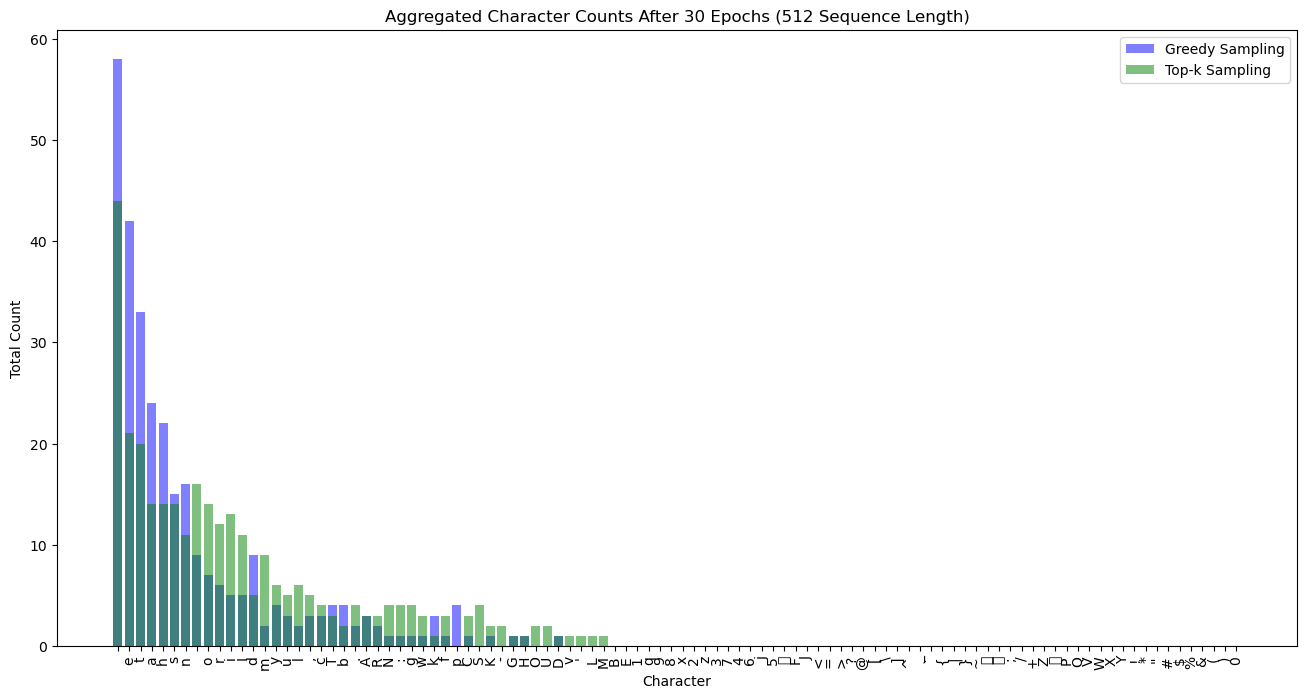

In [76]:
visualize_generated_texts(greedy_samples_512, topk_samples_512)
visualize_character_distribution(greedy_predictions_512, topk_predictions_512, train_dataset.all_characters, 512)

In [77]:
greedy_samples_256, topk_samples_256, greedy_predictions_256, topk_predictions_256, perplexities_256 = train_model(chunk_len=256)

Training - Epoch: 1/30: 10240chunks [00:12, 811.89chunks/s, loss=3.1, lr=0.005, run:=LSTM]                             
Training - Epoch: 2/30: 10240chunks [00:11, 878.56chunks/s, loss=2.44, lr=0.005, run:=LSTM]                            
Training - Epoch: 3/30: 10240chunks [00:11, 880.62chunks/s, loss=2.21, lr=0.005, run:=LSTM]                            
Training - Epoch: 4/30: 10240chunks [00:11, 855.44chunks/s, loss=2.1, lr=0.005, run:=LSTM]                             
Training - Epoch: 5/30: 10240chunks [00:11, 861.10chunks/s, loss=1.94, lr=0.005, run:=LSTM]                            
Training - Epoch: 6/30: 10240chunks [00:12, 807.99chunks/s, loss=1.82, lr=0.005, run:=LSTM]                            
Training - Epoch: 7/30: 10240chunks [00:12, 845.18chunks/s, loss=1.85, lr=0.005, run:=LSTM]                            
Training - Epoch: 8/30: 10240chunks [00:12, 810.56chunks/s, loss=1.71, lr=0.005, run:=LSTM]                            
Training - Epoch: 9/30: 10240chunks [00:

-----------------EPOCH 1---------------------
Greedy:
O Romeo, wherefore art thou                                                                                                                                                                                                                                                                                                            

Top-K:
O Romeo, wherefore art thouthe na tont tone   a  a  ther n    to  te s tet t t  h stoooe thenoe  th theet  ae toneron st sorttetot oto s terere ond oo nt   t oo  o s the s  t te thendt n th ot o o  et ot se s ntont nttha t than  e o erese no   ooeee stt t stt t  a eonothen  aot t tanoer t t    oent t tore stendotottoe  t  ot 
---------------------------------------------

-----------------EPOCH 6---------------------
Greedy:
O Romeo, wherefore art thou have the will the prome the will the prome the will the prome the will the prome the will the prome the will the prome the will the prome the will the pr

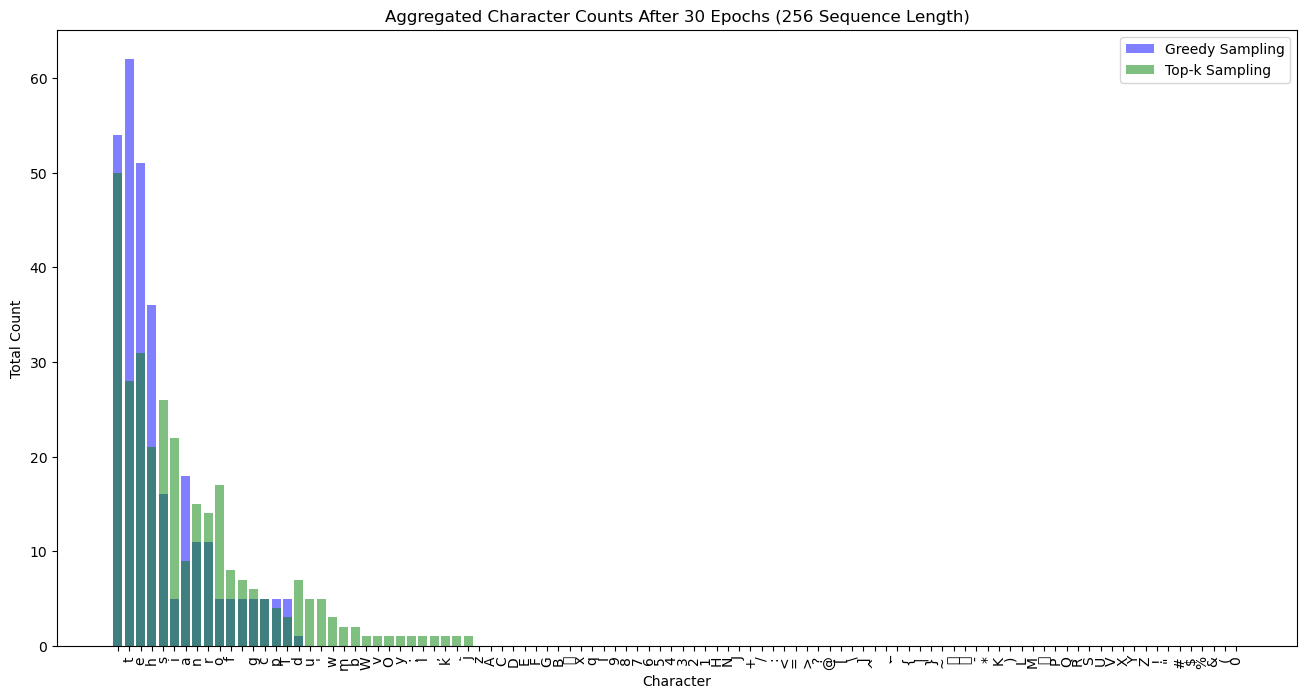

In [78]:
visualize_generated_texts(greedy_samples_256, topk_samples_256)
visualize_character_distribution(greedy_predictions_256, topk_predictions_256, train_dataset.all_characters, 256)

In [79]:
greedy_samples_128, topk_samples_128, greedy_predictions_128, topk_predictions_128, perplexities_128 = train_model(chunk_len=128)

Training - Epoch: 1/30: 10240chunks [00:07, 1423.88chunks/s, loss=2.98, lr=0.005, run:=LSTM]                           
Training - Epoch: 2/30: 10240chunks [00:06, 1518.18chunks/s, loss=2.47, lr=0.005, run:=LSTM]                           
Training - Epoch: 3/30: 10240chunks [00:06, 1511.50chunks/s, loss=2.28, lr=0.005, run:=LSTM]                           
Training - Epoch: 4/30: 10240chunks [00:06, 1490.24chunks/s, loss=2.13, lr=0.005, run:=LSTM]                           
Training - Epoch: 5/30: 10240chunks [00:06, 1494.90chunks/s, loss=1.99, lr=0.005, run:=LSTM]                           
Training - Epoch: 6/30: 10240chunks [00:07, 1376.74chunks/s, loss=1.89, lr=0.005, run:=LSTM]                           
Training - Epoch: 7/30: 10240chunks [00:07, 1452.96chunks/s, loss=1.85, lr=0.005, run:=LSTM]                           
Training - Epoch: 8/30: 10240chunks [00:07, 1443.75chunks/s, loss=1.78, lr=0.005, run:=LSTM]                           
Training - Epoch: 9/30: 10240chunks [00:

-----------------EPOCH 1---------------------
Greedy:
O Romeo, wherefore art thou the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the

Top-K:
O Romeo, wherefore art thou ae ete sese e ethetht t tht stth s th ease easeth shathottottor a  ooshot eat shaeotht thetoth atho the s ees  hon s ttho ee aee s e tt sorath oero hottoes torestetht ton ter e ath eee t to a e an soth oe  eesesthe  ot eee  hieo ant soe  onesett et atheres eatte  eort ho t sth o  h  honsoeseeso ao 
---------------------------------------------

-----------------EPOCH 6---------------------
Greedy:
O Romeo, wherefore art thou have the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the sore the 

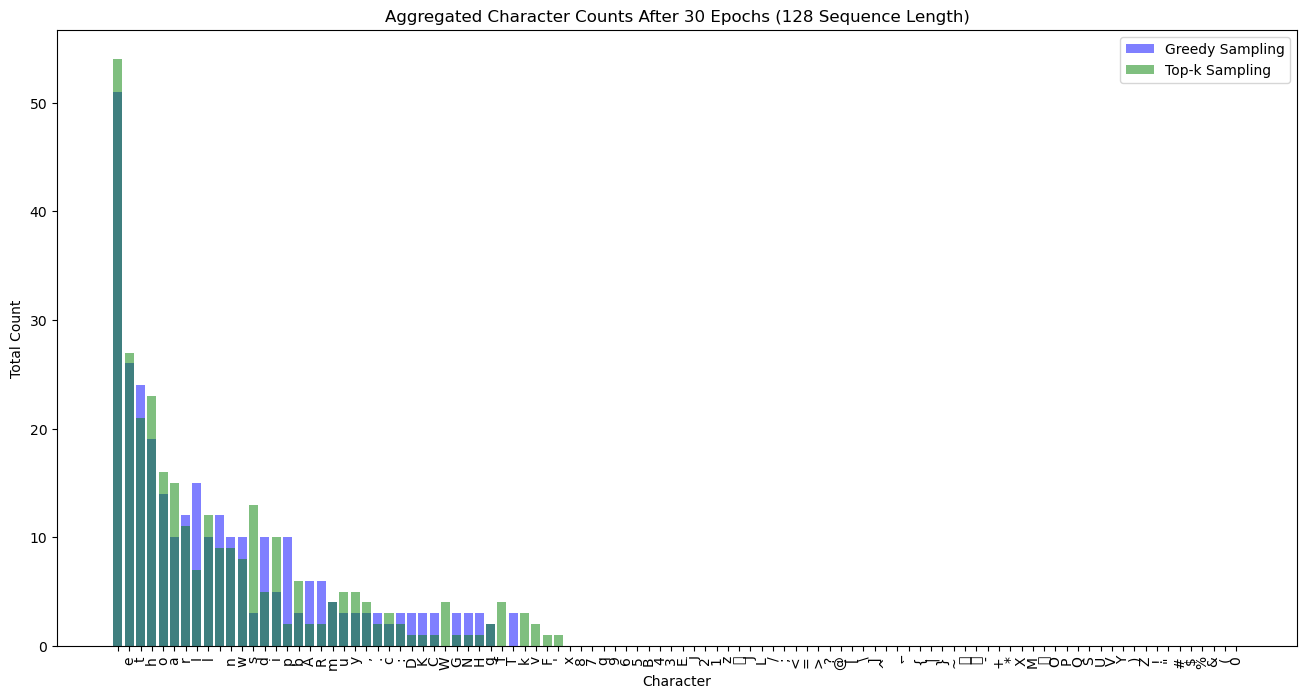

In [80]:
visualize_generated_texts(greedy_samples_128, topk_samples_128)
visualize_character_distribution(greedy_predictions_128, topk_predictions_128, train_dataset.all_characters, 128)

In [81]:
greedy_samples_64, topk_samples_64, greedy_predictions_64, topk_predictions_64, perplexities_64 = train_model(chunk_len=64)

Training - Epoch: 1/30: 10240chunks [00:04, 2358.87chunks/s, loss=3.02, lr=0.005, run:=LSTM]                           
Training - Epoch: 2/30: 10240chunks [00:03, 2597.59chunks/s, loss=2.51, lr=0.005, run:=LSTM]                           
Training - Epoch: 3/30: 10240chunks [00:03, 2632.41chunks/s, loss=2.25, lr=0.005, run:=LSTM]                           
Training - Epoch: 4/30: 10240chunks [00:03, 2566.90chunks/s, loss=2.13, lr=0.005, run:=LSTM]                           
Training - Epoch: 5/30: 10240chunks [00:03, 2609.66chunks/s, loss=2.08, lr=0.005, run:=LSTM]                           
Training - Epoch: 6/30: 10240chunks [00:04, 2369.83chunks/s, loss=1.97, lr=0.005, run:=LSTM]                           
Training - Epoch: 7/30: 10240chunks [00:04, 2552.75chunks/s, loss=1.92, lr=0.005, run:=LSTM]                           
Training - Epoch: 8/30: 10240chunks [00:04, 2558.07chunks/s, loss=1.98, lr=0.005, run:=LSTM]                           
Training - Epoch: 9/30: 10240chunks [00:

-----------------EPOCH 1---------------------
Greedy:
O Romeo, wherefore art thou te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te te

Top-K:
O Romeo, wherefore art thoust ea te o son  h eans th o the oetose so sheon e thatheon th s see te etete sothee tete  aon ohtt athaee t to eat  o s s th s e the sotet thas  t othtte te o s sot aootte ote seto to so to o o et oe tht e toteont t oo  e ta eoe  eth oanot  e  oettee t e ee s th s thee tee t e to eet aeoe  etttthe  
---------------------------------------------

-----------------EPOCH 6---------------------
Greedy:
O Romeo, wherefore art thou the sould the seath the pare the sould the sould the sould the sould the sould the sould the sould the sould the sould the sould the sould the sould the 

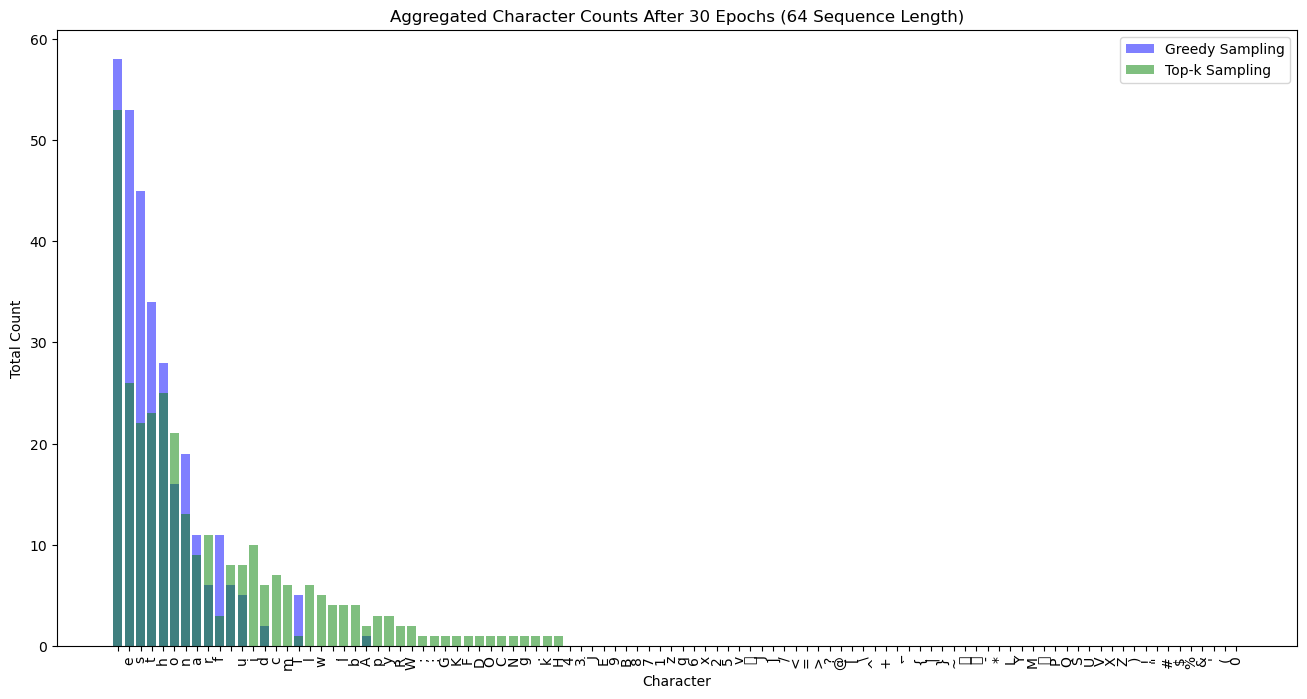

In [82]:
visualize_generated_texts(greedy_samples_64, topk_samples_64)
visualize_character_distribution(greedy_predictions_64, topk_predictions_64, train_dataset.all_characters, 64)

In [83]:
greedy_samples_32, topk_samples_32, greedy_predictions_32, topk_predictions_32, perplexities_32 = train_model(chunk_len=32)

Training - Epoch: 1/30: 10240chunks [00:03, 3113.50chunks/s, loss=3.13, lr=0.005, run:=LSTM]                           
Training - Epoch: 2/30: 10240chunks [00:02, 3868.71chunks/s, loss=2.51, lr=0.005, run:=LSTM]                           
Training - Epoch: 3/30: 10240chunks [00:02, 3837.33chunks/s, loss=2.28, lr=0.005, run:=LSTM]                           
Training - Epoch: 4/30: 10240chunks [00:02, 3836.63chunks/s, loss=2.23, lr=0.005, run:=LSTM]                           
Training - Epoch: 5/30: 10240chunks [00:02, 3717.63chunks/s, loss=2.14, lr=0.005, run:=LSTM]                           
Training - Epoch: 6/30: 10240chunks [00:03, 3237.92chunks/s, loss=2.14, lr=0.005, run:=LSTM]                           
Training - Epoch: 7/30: 10240chunks [00:02, 3895.80chunks/s, loss=2.03, lr=0.005, run:=LSTM]                           
Training - Epoch: 8/30: 10240chunks [00:02, 3674.16chunks/s, loss=1.83, lr=0.005, run:=LSTM]                           
Training - Epoch: 9/30: 10240chunks [00:

-----------------EPOCH 1---------------------
Greedy:
O Romeo, wherefore art thou                                                                                                                                                                                                                                                                                                            

Top-K:
O Romeo, wherefore art thoute t eo   e t ao e  t  at t  atheea o oae  at    a  a t tooan e toe t aeeee e eeaa o atot te  aeooat t a tees  e th oa e e at aeteo  e  o t e t aa e eeante     atoaeo t e  e aat eo oa  e  a ae  athee a ooe   at   e  o  et e e t   eo theteo  o e te t t o o t  t  ae eot  toees to tet at a o at eaeee a
---------------------------------------------

-----------------EPOCH 6---------------------
Greedy:
O Romeo, wherefore art thou have the will the will the will the will the will the will the will the will the will the will the will the will the will the will the will the will the 

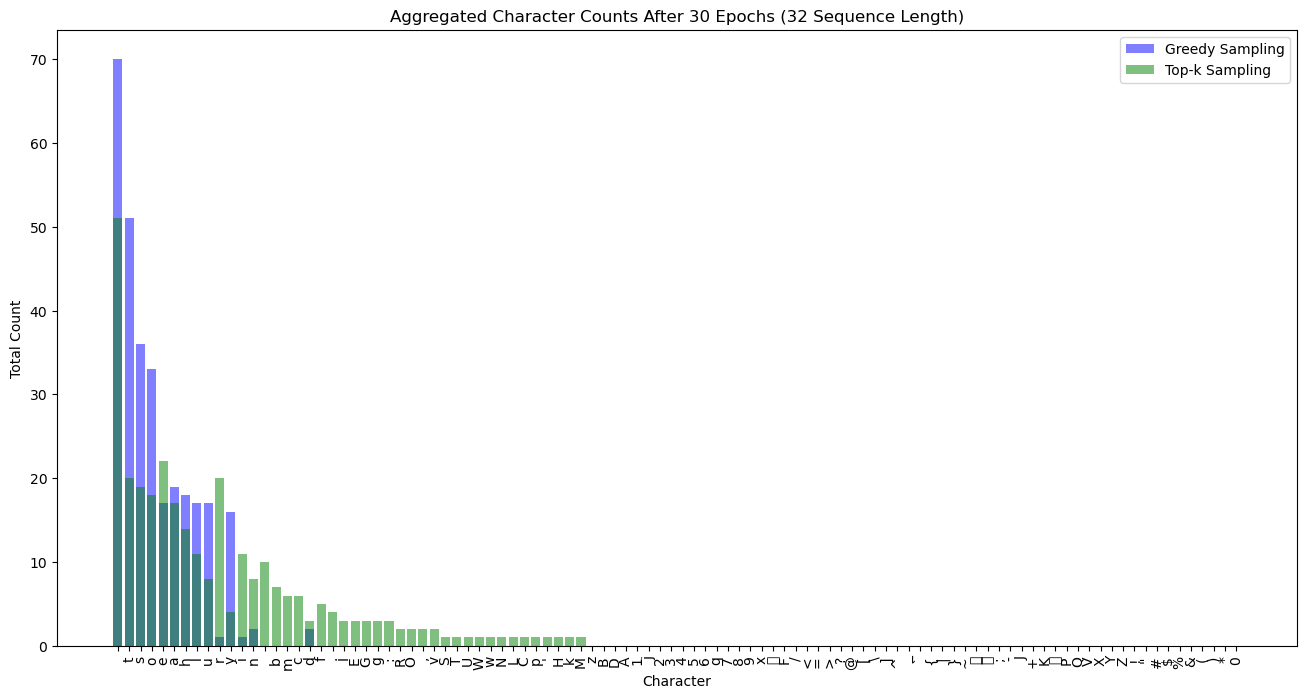

In [84]:
visualize_generated_texts(greedy_samples_32, topk_samples_32)
visualize_character_distribution(greedy_predictions_32, topk_predictions_32, train_dataset.all_characters, 32)

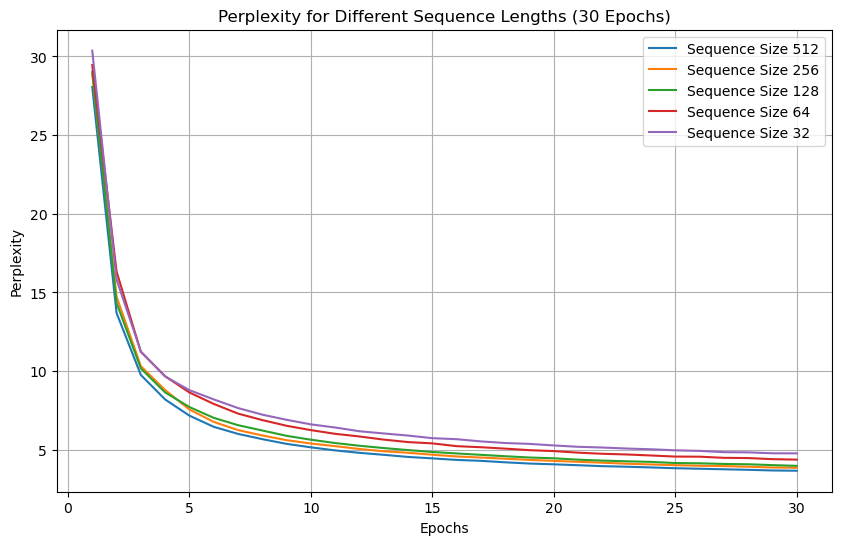

In [86]:
sequence_lengths = [512, 256, 128, 64, 32]
perplexities = [perplexities_512, perplexities_256, perplexities_128, perplexities_64, perplexities_32]

epochs = range(1, 31) 

plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(epochs, perplexities[i], label=f"Sequence Size {sequence_lengths[i]}")

plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.title('Perplexity for Different Sequence Lengths (30 Epochs)')
plt.legend()
plt.grid(True)
plt.show()

# Task 2: Character generation transformer network implementation
Our simple transformer-like network will take as input a sequence of characters and predict the next character in the sequence. To ensure an efficient training procedure, masked attention modules will be used as in the [GPT model](https://s3-us-west-2.amazonaws.com/openai-assets/research-covers/language-unsupervised/language_understanding_paper.pdf).

For this task you must implement the Scaled dot product attention module and the Masked multi-head attention module. Both of these modules are described in the [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf) paper (See Figure 2 in the paper as well as Sections 3.2.1, 3.2.2 and 3.2.3). They are the core operations of transformers. As we will use our model for text generation also add the masking operation shown as (mask opt.) in Figure 2, implemented as AttentionMasking in the code.

**Implement the modules in the ScaledDotProductAttention class and the MultiHeadAttention class.**

Read the GPT paper and the Attention is all you need paper for a better understanding of the components. For a more high level overview, this [post](https://jalammar.github.io/illustrated-gpt2/) may also be helpful.


In [4]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, max_len=1000):
    super().__init__()
    # Positional encoding adds the positional information to the
    # embedding. Without it the model would not be able to differentiate
    # between different characters orders such as between "dog" and "god".
    position = torch.arange(max_len).unsqueeze(1).float()
    div_term = 10000.0**(torch.arange(0,d_model,2).float()/d_model)
    pe = torch.zeros(max_len, d_model)
    pe[:, 0::2] = torch.sin(position / div_term)
    pe[:, 1::2] = torch.cos(position / div_term)
    pe = pe.unsqueeze(0)
    self.pe = pe.cuda()
    self.pe.requires_grad = False


  def forward(self, x):
    p = self.pe[:, :x.size(1)]

    return p

In [5]:
class AttentionMasking(nn.Module):
  def __init__(self, max_len):
    super(AttentionMasking, self).__init__()
    self.register_buffer("mask", torch.tril(torch.ones(max_len, max_len)).view(1, 1, max_len, max_len))


  def forward(self, x):
    length = x.shape[-1]
    out = x.masked_fill(self.mask[:,:,:length,:length] == 0, float('-inf'))

    return out

In [6]:
class ScaledDotProductAttention(nn.Module):
  def __init__(self, max_len):
    super(ScaledDotProductAttention, self).__init__()
    self.softmax = nn.Softmax(dim=-1)
    # Multiply with an upper triangular
    # matrix of dimensions (length x length) after the scale operation
    # in Figure 2 of the paper.
    self.mask_opt = AttentionMasking(max_len)


  def forward(self, q, k, v):
    # length = number of input tokens
    batch_size, num_heads, length, num_neuron = k.size()

    scale = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(num_neuron)
    mask = self.mask_opt(scale)
    softmax = self.softmax(mask)
    out = torch.matmul(softmax, v)

    return out

In [7]:
class MultiHeadAttention(nn.Module):
  def __init__(self, dim_model, num_neuron, n_head, max_len):
    super(MultiHeadAttention, self).__init__()
    self.n_head = n_head
    self.num_neuron = num_neuron

    self.attention = ScaledDotProductAttention(max_len)
    self.q_proj = nn.Linear(dim_model, num_neuron * n_head)
    self.k_proj = nn.Linear(dim_model, num_neuron * n_head)
    self.v_proj = nn.Linear(dim_model, num_neuron * n_head)

    self.proj = nn.Linear(num_neuron * n_head, dim_model)

  def split(self,tensor):
    batch_size, length, total_dim = tensor.size()
    # Reshape the tensor to enable the use in
    # the ScaledDotProductAttention module
    split_tensor = tensor.view(batch_size, length, self.n_head, self.num_neuron).transpose(1,2)
    return split_tensor


  def concat(self,tensor):
    batch_size, num_heads, length, num_neuron = tensor.size()
    # Reshape the tensor to its original size before the split operation.
    concat_tensor = tensor.transpose(1,2).contiguous().view(batch_size, length, self.n_head*self.num_neuron)
    return concat_tensor


  def forward(self, q, k, v):
    q_proj = self.q_proj(q)
    k_proj = self.k_proj(k)
    v_proj = self.v_proj(v)

    q_multi = self.split(q_proj)
    k_multi = self.split(k_proj)
    v_multi = self.split(v_proj)

    attention_multi = self.attention(q_multi, k_multi, v_multi)
    attention_concat = self.concat(attention_multi)
    out = self.proj(attention_concat)

    return out

In [8]:
class PositionFeedForwardNet(nn.Module):
  def __init__(self, dim_model):
    super(PositionFeedForwardNet, self).__init__()
    self.ff_net1 = nn.Linear(dim_model, dim_model*4)
    self.ff_net2 = nn.Linear(dim_model*4, dim_model)


  def forward(self,x):
    ff_out = self.ff_net1(x)
    ff_out = torch.nn.functional.relu(ff_out)
    ff_out = self.ff_net2(ff_out)
    return ff_out

In [9]:
class TransformerBlock(nn.Module):
  def __init__(self, dim_model, num_neuron, n_head, max_len):
    super(TransformerBlock, self).__init__()
    self.mha = MultiHeadAttention(dim_model, num_neuron, n_head, max_len)
    self.l_norm = torch.nn.LayerNorm(dim_model)
    self.l_norm2 = torch.nn.LayerNorm(dim_model)
    self.ff_net = PositionFeedForwardNet(dim_model)
    # b, len_seq, n_head, num_neuron


  def forward(self, x):
    # A Transformer block as described in the
    # Attention is all you need paper. In Figure 1 the transformer
    # block is marked with a gray rectangle right of the text "Nx"
    _x = x
    mha1 = self.mha(x, x, x)
    lnorm = self.l_norm(_x + mha1)
    _x = lnorm
    ff_out = self.ff_net(lnorm)
    out = self.l_norm2(ff_out + _x)

    return out

In [10]:
class TransformerSimple(nn.Module):
  def __init__(self, seq_length, input_dim, output_dim, batch_size):
    super(TransformerSimple, self).__init__()
    num_neuron = 64
    n_head = 8
    dim_model=256
    max_len = 512
    self.start_embedding = nn.Embedding(input_dim, dim_model)

    self.pos_embedding = PositionalEncoding(dim_model)

    # b x l x c*n_head
    self.t_block1 = TransformerBlock(dim_model, num_neuron, n_head, max_len)
    self.t_block2 = TransformerBlock(dim_model, num_neuron, n_head, max_len)
    self.t_block3 = TransformerBlock(dim_model, num_neuron, n_head, max_len)
    self.t_block4 = TransformerBlock(dim_model, num_neuron, n_head, max_len)
    self.t_block5 = TransformerBlock(dim_model, num_neuron, n_head, max_len)

    self.output_layer = nn.Linear(dim_model, output_dim)


  def forward(self,x):
    # x - Tensor - (b, seq_len)
    # Embeds the input tensor from tokens to features
    s_emb = self.start_embedding(x)
    # Adds positional embeddings
    p_emb = self.pos_embedding(s_emb)
    b_out = p_emb + s_emb
    # Transformer blocks - You can experiment with varying depth
    # For example GPT uses 12 blocks but this might be a bit memory intensive
    b_out = self.t_block1(b_out)
    b_out = self.t_block2(b_out)
    b_out = self.t_block3(b_out)
    b_out = self.t_block4(b_out)
    b_out = self.t_block5(b_out)

    # Output mapping to a classification of output tokens
    # For each token the network tries to predict the next token
    # based only on the previous tokens.
    # Output shape: (b x seq_len x vocabulary_size)
    out = self.output_layer(b_out)

    return out

## Dataset class


In [11]:
class TextDataset(Dataset):
  def __init__(self, chunk_len=200, padded_chunks=False):
    # Character based dataset
    dataset_path = "./input.txt"
    # The tokens in the vocabulary (all_characters)
    # are just the printable characters of the string class
    self.all_characters = string.printable
    self.n_characters = len(self.all_characters)
    # Maps characters to indices
    self.char_dict = { x:i for i, x in enumerate(self.all_characters) }
    self.file, self.file_len = self.read_file(dataset_path)
    # Sequence length of the input
    self.chunk_len = chunk_len
    self.encoded_file = [self.char_dict[x] for x in self.file]


  def read_file(self, filename):
    file = unidecode.unidecode(open(filename).read())
    return file, len(file)


  def encode_text(self, in_str):
    # in_str - input sequence - String
    # Returns - in_str mapped to tokens in char_dict
    tensor = torch.LongTensor([self.char_dict[x] for x in in_str])
    return tensor


  def __getitem__(self, idx):
    inp, target = self.get_random_text()
    return { "input": inp, "target": target }


  def __len__(self):
    return 10000


  def get_random_text(self):
    # Pick a random string of length self.chunk_len from the dataset
    start_index = np.random.randint(0, self.file_len - self.chunk_len)
    end_index = start_index + self.chunk_len + 1
    chunk = self.encoded_file[start_index:end_index]
    # input_tokens - random sequence of tokens from the dataset
    input_tokens = torch.LongTensor(chunk[:-1])
    # target - input token sequence shifted by 1
    # the idea is to predict next token for each token in the input sequence
    # therefore if the input is [1,2,3,4] the target is [2,3,4,5]
    target = torch.LongTensor(chunk[1:])
    input_tokens = input_tokens.cuda()
    target = target.cuda()
    return input_tokens, target

## Character sampling

To generate text the network must predict the next character in a sequence, however networks do not produce a single character but rather estimate the likelihood for each possible character. Sampling characters from the network output can be done in different ways with common ones being the Greedy sampling process and Top-K sampling.

In the simple greedy sampling method the network takes a text prompt as input and generates an additional N tokens by always taking the token with the highest prediction score as the next token.

In the Top-K sampling, randomness is added to the sampling process as the network samples from K most likely predicitons at each step. This alleviates the problem of generative models repeating text but may generate incorrect text by sampling inappropriate tokens.


In [12]:
def topk_sampling_iter_transformer(model, x, num_chars, chunk_len, output_token):
  # x -- b x onehot_char
  # x = b x l
  outputs = torch.zeros((1,num_chars))
  inp = x

  for t in range(num_chars):
    # b x onehot_char
    output = model(inp.long())[0,-1:]
    #output = torch.softmax(output, dim=1)
    # b x 3
    output_vals, output_ind = torch.topk(output, 5, dim=1)
    # 3 -> int
    output_vals = torch.softmax(output_vals, dim=1)
    top_ind = torch.multinomial(output_vals[0], 1)[0]
    # int
    out_char_index = output_ind[0,top_ind]
    # int -> 1
    out_char_index = torch.ones(1).cuda() * out_char_index

    outputs[:,t] = out_char_index.item()
    if inp.shape[1] > chunk_len:
      inp = torch.cat((inp[:,1:], out_char_index.unsqueeze(0)), dim=1)
    else:
      inp = torch.cat((inp, out_char_index.unsqueeze(0)), dim=1)

  return outputs


def greedy_sampling_iter_transformer(model, x, num_chars, chunk_len, output_token):
  # x -- shape (batch, tokens in x)
  outputs = torch.zeros((1,num_chars))
  inp = x

  for t in range(num_chars):
    # b x l x onehot_char
    output = model(inp.long())[0,-1:]
    output = torch.softmax(output, dim=1)
    out_char_index = torch.argmax(output, dim=1)
    outputs[:,t] = out_char_index.item()
    if inp.shape[1] > chunk_len:
      inp = torch.cat((inp[:,1:], out_char_index.unsqueeze(0)), dim=1)
    else:
      inp = torch.cat((inp, out_char_index.unsqueeze(0)), dim=1)

  return outputs

In [32]:
def visualize_character_distribution(greedy_indices, topk_indices, all_characters, seq_len):
    epochs = len(greedy_indices)
    num_characters = len(all_characters)

    last_epoch_index = len(greedy_indices) - 1
    last_epoch_greedy_counts = np.zeros(num_characters)
    last_epoch_topk_counts = np.zeros(num_characters)

    for idx in greedy_indices[last_epoch_index]:
        last_epoch_greedy_counts[idx] += 1
    for idx in topk_indices[last_epoch_index]:
        last_epoch_topk_counts[idx] += 1

    total_greedy_counts = last_epoch_greedy_counts
    total_topk_counts = last_epoch_topk_counts

    sorted_indices = np.argsort(total_greedy_counts + total_topk_counts)[::-1]
    sorted_characters = [all_characters[i] for i in sorted_indices]

    plt.figure(figsize=(16,8))
    plt.bar(range(num_characters), total_greedy_counts[sorted_indices], color='blue', alpha=0.5, label='Greedy Sampling')
    plt.bar(range(num_characters), total_topk_counts[sorted_indices], color='green', alpha=0.5, label='Top-k Sampling')
    plt.xlabel('Character')
    plt.ylabel('Total Count')
    plt.title(f'Aggregated Character Counts After 50 Epochs ({seq_len} Sequence Length)')
    plt.xticks(range(num_characters), sorted_characters, rotation=90)
    plt.legend()
    plt.show()

In [23]:
def visualize_generated_texts(greedy_texts, topk_texts):
    epochs = len(greedy_texts)

    for i in range(epochs):
        if (i == epochs - 1):
          print(f"-----------------EPOCH 50---------------------")
        else:    
          print(f"-----------------EPOCH {i * 5 + 1}---------------------")
        print("Greedy:")
        print(greedy_texts[i])
        print()
        print("Top-K:")
        print(topk_texts[i])
        print("---------------------------------------------")
        print()

In [ ]:
def train_model(batch_size=256, chunk_len=256, hidden_dim=256, learning_rate=0.005, epochs=30, sample_text="O Romeo, wherefore art thou"):
    train_dataset = TextDataset(chunk_len=chunk_len)
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=0)
    
    input_dim = train_dataset.n_characters
    output_dim = train_dataset.n_characters
    learning_rate = 0.0006
    
    model = TransformerSimple(chunk_len, input_dim, output_dim, batch_size)
    model.train()
    model.cuda()
    
    criterion = nn.CrossEntropyLoss()
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    epochs=50
    
    output_token = torch.zeros(1,1).cuda()
    output_token[0,0] = train_dataset.n_characters-1

    evaluate_counter = 4
    sample_encoding = train_dataset.encode_text(sample_text)
    sample_input = Variable(sample_encoding).cuda().unsqueeze(0).long()
    topk_samples, topk_predictions = [], []
    greedy_samples, greedy_predictions = [], []
    perplexities = []
    
    for epoch in range(epochs):
      evaluate_counter += 1
      total_loss = 0
      total_batches = 0
      with tqdm(total=len(trainloader.dataset), desc ='Training - Epoch: ' + str(epoch + 1) + "/" + str(epochs), unit='chunks') as prog_bar:
        for i, data in enumerate(trainloader, 0):
          inputs = data['input'].long()
          labels = data['target'].long()
    
          optimizer.zero_grad()
          outputs = model(inputs)
          target_t = labels
          loss = criterion(outputs.view(inputs.shape[0] * inputs.shape[1], -1), target_t.view(labels.shape[0] * labels.shape[1]))
          total_loss += loss.item()
          total_batches += 1
            
          loss.backward()
          optimizer.step()
            
          prog_bar.set_postfix(**{ 'run:': "Transformer", 'lr': learning_rate, 'loss': loss.item() })
          prog_bar.update(batch_size)

        perplexities.append(np.exp(total_loss / total_batches))
        if evaluate_counter == 5 or epoch == epochs - 1:
            out_test= greedy_sampling_iter_transformer(model, sample_input, 400, chunk_len, output_token)[0]
            out_char_index = out_test.long().detach().cpu().numpy()
            out_chars = sample_text + "".join([train_dataset.all_characters[i] for i in out_char_index])
            greedy_samples.append(out_chars)
            greedy_predictions.append(out_char_index)
    
            out_test= topk_sampling_iter_transformer(model, sample_input, 400, chunk_len, output_token)[0]
            out_char_index = out_test.long().detach().cpu().numpy()
            out_chars = sample_text + "".join([train_dataset.all_characters[i] for i in out_char_index])
            topk_samples.append(out_chars)
            topk_predictions.append(out_char_index)
            evaluate_counter = 0

    return greedy_samples, topk_samples, greedy_predictions, topk_predictions, perplexities

## Transformer model training

With a correct implementation you should get sensible text generation results with the set parameters, however you should experiment with various parameters,
especially with the sequence length (chunk_len) used during training.

In [21]:
greedy_samples_32, topk_samples_32, greedy_predictions_32, topk_predictions_32, perplexities_32 = train_model(chunk_len=32)

Training - Epoch: 1/50: 10240chunks [00:26, 389.00chunks/s, loss=2.43, lr=0.0006, run:=Transformer]                    
Training - Epoch: 2/50: 10240chunks [00:17, 573.95chunks/s, loss=2.26, lr=0.0006, run:=Transformer]                    
Training - Epoch: 3/50: 10240chunks [00:17, 569.45chunks/s, loss=2.01, lr=0.0006, run:=Transformer]                    
Training - Epoch: 4/50: 10240chunks [00:17, 571.73chunks/s, loss=1.78, lr=0.0006, run:=Transformer]                    
Training - Epoch: 5/50: 10240chunks [00:17, 572.80chunks/s, loss=1.73, lr=0.0006, run:=Transformer]                    
Training - Epoch: 6/50: 10240chunks [00:21, 487.34chunks/s, loss=1.75, lr=0.0006, run:=Transformer]                    
Training - Epoch: 7/50: 10240chunks [00:17, 574.57chunks/s, loss=1.76, lr=0.0006, run:=Transformer]                    
Training - Epoch: 8/50: 10240chunks [00:17, 571.88chunks/s, loss=1.63, lr=0.0006, run:=Transformer]                    
Training - Epoch: 9/50: 10240chunks [00:

-----------------EPOCH 1---------------------
Greedy:
O Romeo, wherefore art thou t t the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the

Top-K:
O Romeo, wherefore art thou he t har h h t hand thisoushill me the aso tho s s ar the, tho shoush te m hile s the s the atofof ar has the h t s he me angouthathe m serou the te se atof hese t thoul t anoule t,
Wiler he asthis mo me at te so mou an athe so anou w mat heso s tousoungr t t,
ANore hanond t, se the shealon t t t and, sthind mathalleat s th he ho the hat s h ange he hind as my.


TERANTIIORD th INIIORDIIORINTION:
---------------------------------------------

-----------------EPOCH 6-----------

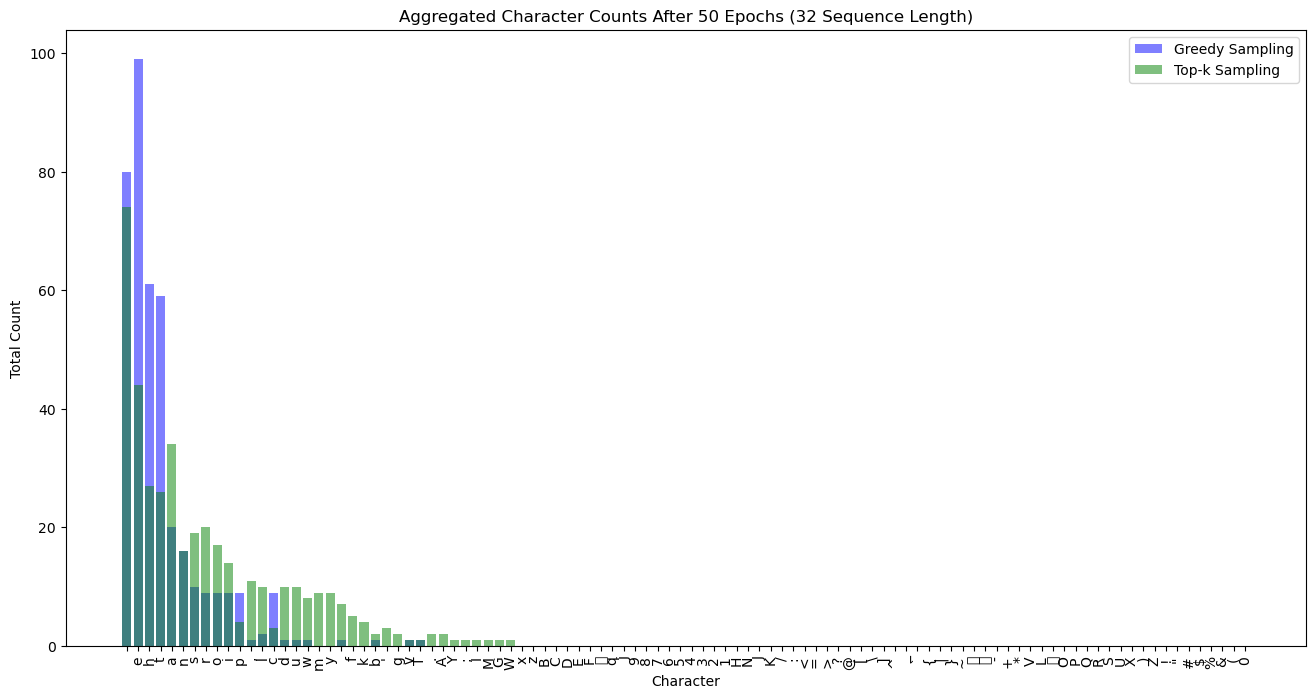

In [33]:
train_dataset = TextDataset(chunk_len=32)
visualize_generated_texts(greedy_samples_32, topk_samples_32)
visualize_character_distribution(greedy_predictions_32, topk_predictions_32, train_dataset.all_characters, 32)

In [34]:
greedy_samples_64, topk_samples_64, greedy_predictions_64, topk_predictions_64, perplexities_64 = train_model(chunk_len=64)

Training - Epoch: 1/50: 10240chunks [01:30, 113.30chunks/s, loss=2.51, lr=0.0006, run:=Transformer]                    
Training - Epoch: 2/50: 10240chunks [01:26, 118.85chunks/s, loss=2.33, lr=0.0006, run:=Transformer]                    
Training - Epoch: 3/50: 10240chunks [01:27, 117.54chunks/s, loss=2.13, lr=0.0006, run:=Transformer]                    
Training - Epoch: 4/50: 10240chunks [01:27, 117.67chunks/s, loss=1.98, lr=0.0006, run:=Transformer]                    
Training - Epoch: 5/50: 10240chunks [01:26, 118.66chunks/s, loss=1.78, lr=0.0006, run:=Transformer]                    
Training - Epoch: 6/50: 10240chunks [01:28, 115.12chunks/s, loss=1.79, lr=0.0006, run:=Transformer]                    
Training - Epoch: 7/50: 10240chunks [01:25, 119.97chunks/s, loss=1.67, lr=0.0006, run:=Transformer]                    
Training - Epoch: 8/50: 10240chunks [01:24, 121.90chunks/s, loss=1.57, lr=0.0006, run:=Transformer]                    
Training - Epoch: 9/50: 10240chunks [01:

-----------------EPOCH 1---------------------
Greedy:
O Romeo, wherefore art thour the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the th

Top-K:
O Romeo, wherefore art thout mand t sour tonou wor angre hathar s t hersindountengere terds t mendo matotes herind andind, thend my t heasth t m tour s hillles thend toule tharin sitereres at thothestere mango he thour theseas toren tin s to ses asenger s tes monor seso mand th at t hing mas as horengher ard s st hit songh an t ates thisto myon t hour t thor h the theane hire herd th stile tono s t andito he at alinthe tile
---------------------------------------------

-----------------EPOCH 6-----------

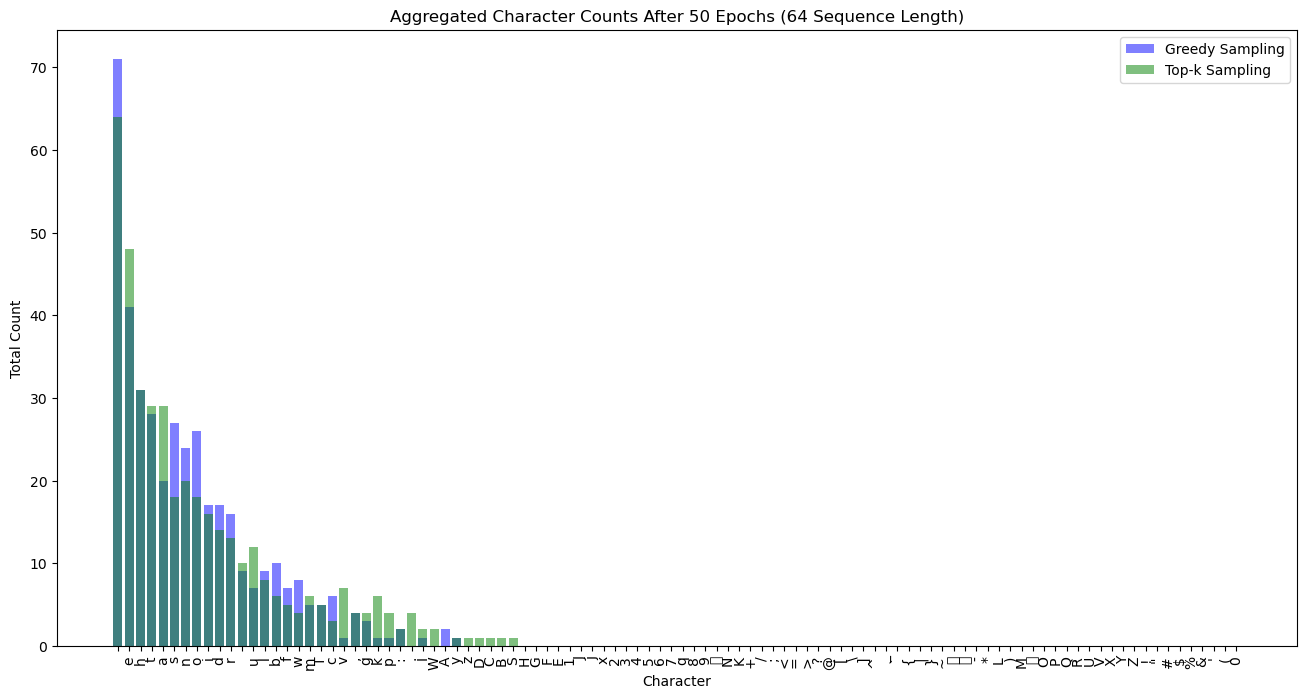

In [35]:
train_dataset = TextDataset(chunk_len=64)
visualize_generated_texts(greedy_samples_64, topk_samples_64)
visualize_character_distribution(greedy_predictions_64, topk_predictions_64, train_dataset.all_characters, 64)

In [36]:
greedy_samples_128, topk_samples_128, greedy_predictions_128, topk_predictions_128, perplexities_128 = train_model(chunk_len=128)

Training - Epoch: 1/50: 10240chunks [01:40, 101.55chunks/s, loss=2.61, lr=0.0006, run:=Transformer]                    
Training - Epoch: 2/50: 10240chunks [01:36, 106.14chunks/s, loss=2.48, lr=0.0006, run:=Transformer]                    
Training - Epoch: 3/50: 10240chunks [01:35, 107.53chunks/s, loss=2.26, lr=0.0006, run:=Transformer]                    
Training - Epoch: 4/50: 10240chunks [01:34, 108.80chunks/s, loss=2.12, lr=0.0006, run:=Transformer]                    
Training - Epoch: 5/50: 10240chunks [01:33, 109.10chunks/s, loss=2.04, lr=0.0006, run:=Transformer]                    
Training - Epoch: 6/50: 10240chunks [01:36, 105.78chunks/s, loss=1.88, lr=0.0006, run:=Transformer]                    
Training - Epoch: 7/50: 10240chunks [01:35, 107.08chunks/s, loss=1.76, lr=0.0006, run:=Transformer]                    
Training - Epoch: 8/50: 10240chunks [01:37, 105.40chunks/s, loss=1.64, lr=0.0006, run:=Transformer]                    
Training - Epoch: 9/50: 10240chunks [01:

-----------------EPOCH 1---------------------
Greedy:
O Romeo, wherefore art thour the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the th

Top-K:
O Romeo, wherefore art thountiserand shinghe me maren thase sth sh tin t t m t myothoth s hathar t hilintharde s tound theshathe he tor sthast athang t mare seat theanot m sere serat tito mean as tend,


Wh s s h horarealo horend the my thin thin har myor mal th tous manour m tond al se tin she s man me to hine s athalore thereris m t thind mesourang hes thest angero hine ho the me me me thaste tirer mand andereatous se as 
---------------------------------------------

-----------------EPOCH 6-----------

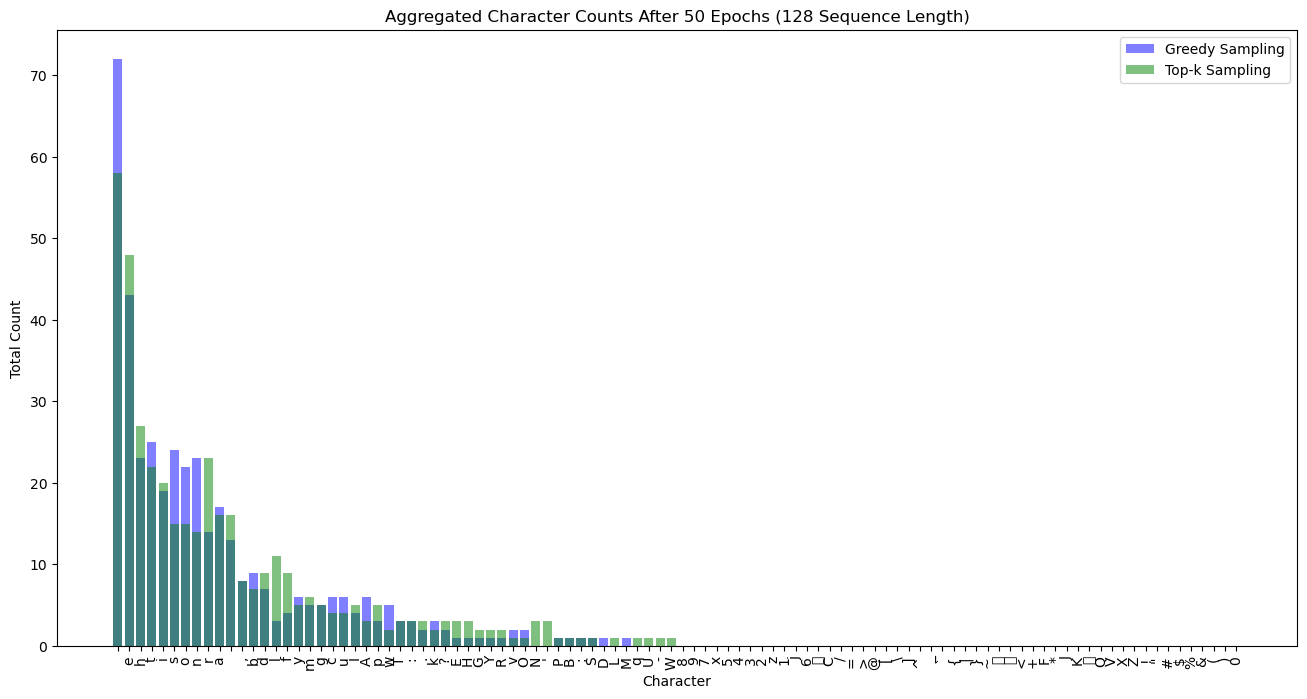

In [37]:
train_dataset = TextDataset(chunk_len=128)
visualize_generated_texts(greedy_samples_128, topk_samples_128)
visualize_character_distribution(greedy_predictions_128, topk_predictions_128, train_dataset.all_characters, 128)

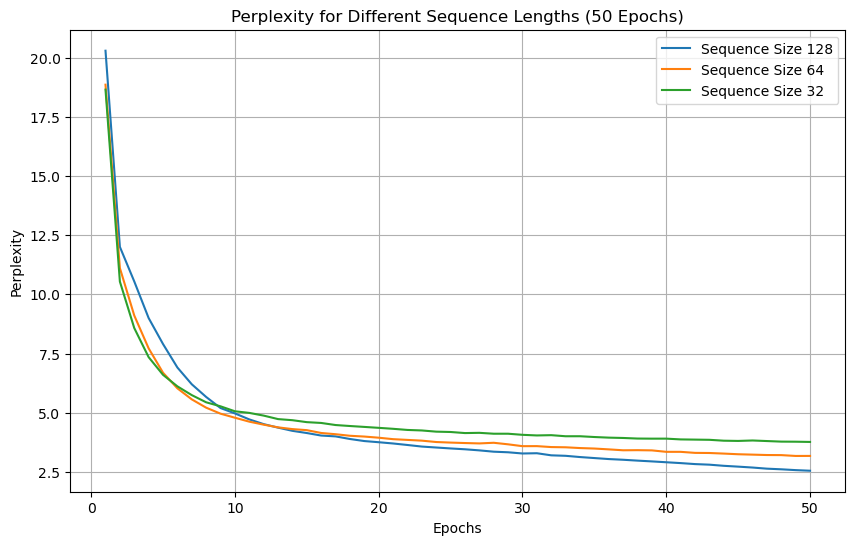

In [40]:
sequence_lengths = [128, 64, 32]
perplexities = [perplexities_128, perplexities_64, perplexities_32]

epochs = range(1, 51) 

plt.figure(figsize=(10, 6))
for i in range(3):
    plt.plot(epochs, perplexities[i], label=f"Sequence Size {sequence_lengths[i]}")

plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.title('Perplexity for Different Sequence Lengths (50 Epochs)')
plt.legend()
plt.grid(True)
plt.show()